In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from training import message_pb2 as protobuf_message_module
from godot_gym_api import GodotClient
from environments.enums import Request
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
config = {
    "agent": {
        "car": {
            "max_steering_angle": 0.2,
            "max_engine_force": 100,
        }
    },
    "environment": {
        "repeat_action": 4,
    }
}

In [4]:
ADDRESS = "localhost"
PORT = 9090
client = GodotClient(protobuf_message_module, (ADDRESS, PORT), chunk_size=65536)
_ = client.configure(config) # Response is meaningless

Waiting for Godot server launch.
Connection is established.


In [5]:
def step(action):
    requested_observation = {
        "agent": [
            # Request.CAMERA,
            # Request.LIDAR,
            # Request.IS_CRASHED,
            # Request.WHEEL_POSITION,
            Request.PARKING_SENSORS,
            # Request.SPEED,
            Request.GLOBAL_COORDINATES,
            Request.INTERNAL_COORDINATES,
        ]
    }
    current_state = client.step(action, requested_observation)
    agent_state = current_state["agent"]
    global_coordinates = agent_state["global_coordinates"]
    internal_coordinates = agent_state["internal_coordinates"]
    parking_sensors = {k: agent_state["parking_sensors"][k].distance[-1] for k in agent_state["parking_sensors"].keys()}
    return global_coordinates, internal_coordinates, parking_sensors

In [6]:
steering_deltas = []
for i in range(200):
    delta = (math.cos(i) - 1) * 0.03 
    steering_deltas.append(delta)

# steering_deltas = [0.01 for _ in range(50)]

global_coordinates = []
internal_coordinates = []
parking_sensors = []
coeff = 1
for i in tqdm(range(len(steering_deltas))):
    action = {
        "steering_delta": steering_deltas[i],
        "engine_force_delta": 20, #choice([-1/50, 1/50]),
    }
    global_coordinates_, internal_coordinates_, parking_sensors_ = step(action)
    global_coordinates.append(global_coordinates_)
    internal_coordinates.append(internal_coordinates_)
    parking_sensors.append(parking_sensors_)

100%|██████████| 200/200 [00:33<00:00,  6.00it/s]


In [7]:
i_xs = []
i_ys = []
i_os = []

g_zs = []
g_xs = []
g_os = []
for i_pos, g_pos in zip(internal_coordinates, global_coordinates):
    i_xs.append(i_pos.x)
    i_ys.append(i_pos.y)
    i_os.append(i_pos.orientation)
    #
    g_zs.append(g_pos.z - global_coordinates[0].z)
    g_xs.append(g_pos.x - global_coordinates[0].x)
    g_os.append(g_pos.orientation - global_coordinates[0].orientation)

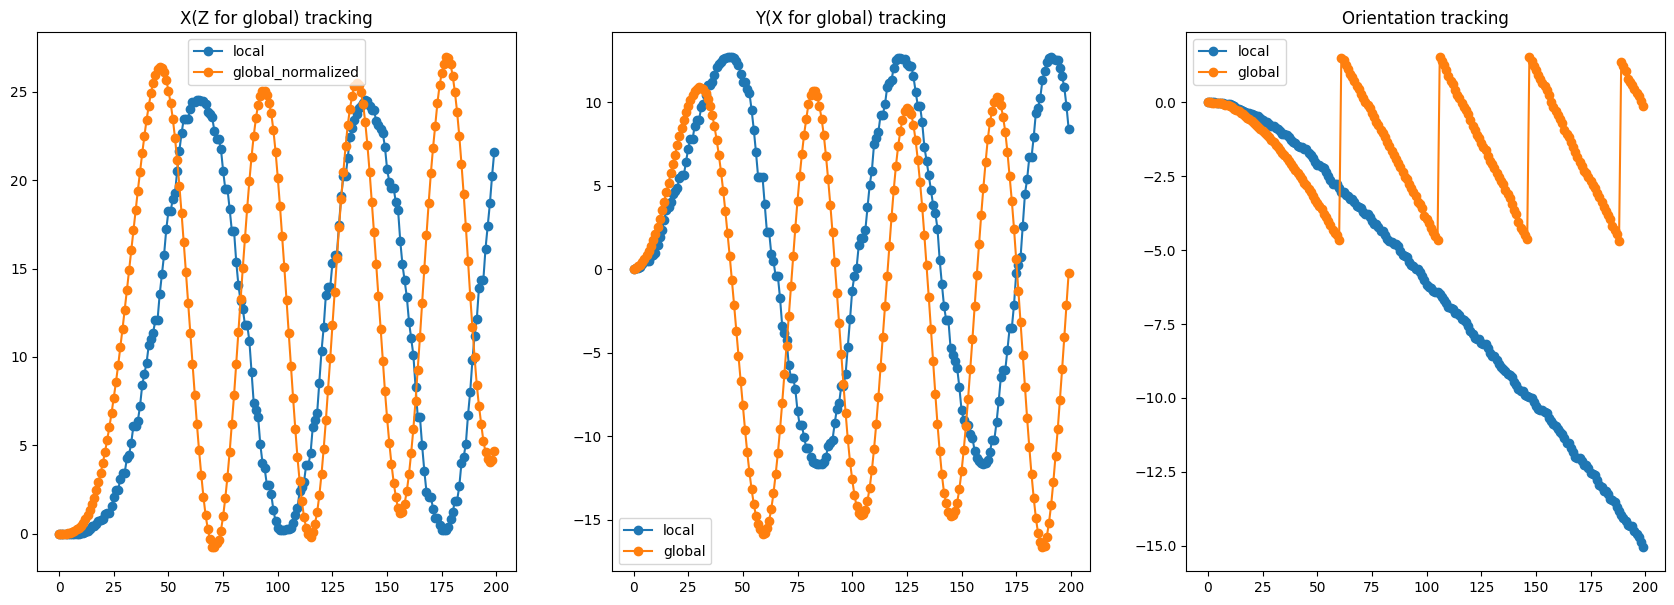

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))
ax[0].plot(i_xs, marker="o", label="local")
ax[0].plot(g_zs, marker="o", label="global_normalized")
ax[0].set_title("X(Z for global) tracking")
ax[0].legend()

ax[1].plot(i_ys, marker="o", label="local")
ax[1].plot(g_xs, marker="o", label="global")
ax[1].set_title("Y(X for global) tracking")
ax[1].legend()

ax[2].plot(i_os, marker="o", label="local")
ax[2].plot(g_os, marker="o", label="global")
ax[2].set_title("Orientation tracking")
ax[2].legend()

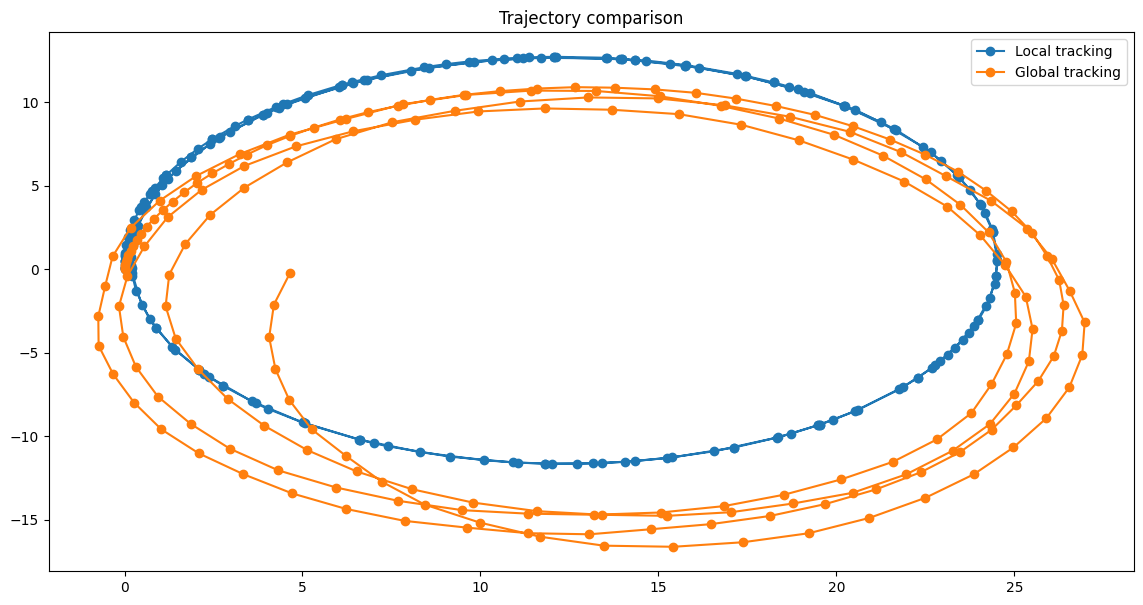

In [9]:
fig, ax = plt.subplots(1, figsize=(14,7))
ax.plot(i_xs, i_ys, marker="o", label="Local tracking")
ax.plot(g_zs, g_xs, marker="o", label="Global tracking")
ax.legend()
plt.title("Trajectory comparison")
plt.show()

In [10]:
# MAX_SENSOR_DIST = 2
# zs = []
# xs = []
# cs = []
# a = 1
# for sensor_data, car_pos in zip(parking_sensors, global_coordinates):
#     x = car_pos.x
#     z = car_pos.z
#     rot_y = car_pos.rot_y
#     angle_mapping = {
#         "Front": 0,
#         "FrontLeft": 45,
#         "FrontRight": -45,
#         "Rear": 180,
#         "RearLeft": 135,
#         "RearRight": -135,
#     }
#     shift_mapping = {
#         "Front": {"x": 0, "z": 1.944},
#         "FrontLeft": {"x": 0.814, "z": 1.944},
#         "FrontRight": {"x": -0.814, "z": 1.944},
#         "Rear": {"x": 0, "z": -2.135},
#         "RearLeft": {"x": 0.819, "z": -2.135},
#         "RearRight": {"x": -0.819, "z": -2.135},
#     }
#     color_mapping = {
#         "FrontRight": 0,
#         "Front": 1,
#         "FrontLeft": 2,
#         "RearLeft": 3,
#         "Rear": 4,
#         "RearRight": 5,
#     }
#     for key, dist in sensor_data.items():
#         if dist < MAX_SENSOR_DIST:
#             angle = angle_mapping[key]  # Check why car orientation is not consisent with its direction of driving
#             dz = math.cos(math.radians(angle)) * dist + shift_mapping[key]["z"]
#             dx = math.sin(math.radians(angle)) * dist + shift_mapping[key]["x"]
#             zs.append(z + math.sin(rot_y) * dz)
#             xs.append(x + math.cos(rot_y) * dx)
#             cs.append(color_mapping[key])

In [11]:
# fig = plt.figure(figsize=(10,10))
# plt.xlabel("Z")
# plt.ylabel("X")
# plt.scatter(zs, xs, label="obstacles", c=cs)
# plt.plot([p.z for p in global_coordinates], [p.x for p in global_coordinates], color="red", label="track")
    
# plt.legend()
# plt.grid()
# plt.show()